# 长沙理工大学2021学年第一学期电费数据分析

介绍：项目数据源为校一卡通开放接口，由爬虫每日爬取后存放到数据库，起始时间（2021年9月20日）
在收集了约一个季度的电费信息后,可以对全校的整体或是单栋寝室楼或者单个寝室的用电情况进行分析,发现用电的时间规律或是气温规律.

如果您对数据分析感兴趣,或是希望获取数据集自行分析,欢迎联系本文作者:chenyi

email:396909028@qq.com

### 1.环境准备

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from JDBCconnect import connect_url

In [2]:
# 初始化数据库连接，使用pymysql模块
engine = create_engine(connect_url)

sql = '''
    select * from electricity;
'''
# read_sql_query的两个参数: sql语句， 数据库连接
df = pd.read_sql_query(sql, engine)

In [3]:
df.dtypes

id                      int64
electricity           float64
aid                    object
roomid                 object
areaname               object
buildingid              int64
building               object
insert_time    datetime64[ns]
dtype: object

In [4]:
latest_date = df.tail(1).loc[:,'insert_time'].astype(str).values[0].split(' ')[0]
print('当前最新数据日期', latest_date)

当前最新数据日期 2021-12-29


---

### 2.天气数据准备

In [5]:
weather = pd.read_csv('./weather.csv')
if weather.tail(1)['date'].values[0] != latest_date:
    print('请运行下方的单元格以更新天气数据！')
else:
    print('数据库与天气数据已同步')


请运行下方的单元格以更新天气数据！


In [6]:
#!python weather_clawler.py

In [7]:
weather['max'] = weather['temperature'].map(lambda x: int(x.split('/')[0]))
weather['min'] = weather['temperature'].map(lambda x: int(x.split('/')[1]))

weather.drop('temperature', axis=1, inplace=True)

In [8]:
weather.tail()

,date,weather,wind,max,min
114,2021-12-24,小雨/小雨,北风1-2级/北风1-2级,12,3
115,2021-12-25,阴/阴,北风1-2级/北风1-2级,3,0
116,2021-12-26,中雪/小雪,北风1-2级/北风1-2级,1,-1
117,2021-12-27,小雪/阴,西北风1-2级/西北风1-2级,0,-1
118,2021-12-28,阴/小雨,北风1-2级/北风1-2级,4,0


---

### 3.数据预处理

In [9]:
# 去除无用列
df = df.drop(['id', 'areaname', 'aid'], axis=1)
# 组装门牌号
df['uid'] = df['building'].astype(str) + df['roomid']
# 简化时间
df['insert_time'] = df['insert_time'].astype(str).map(lambda x: x.split(' ')[0])

In [10]:
# 准备反向map的字典
room_map = {}
reverse_map = {}
room_list = list(df['uid'].unique())

for idx, room in enumerate(room_list):
    room_map[room] = idx
    reverse_map[idx] = room 

In [11]:
# 为每一个房间设置唯一id 便于之后操作
df['uid'] = df['uid'].map(room_map)

In [12]:
# 拼接地址 简化数据字段
df['room'] = df['building'] + '-' + df['roomid']
df = df.drop(['building', 'roomid'], axis=1)
df.head()

,electricity,buildingid,insert_time,uid,room
0,29.15,471,2021-09-20,0,16栋A区-A201
1,201.50,471,2021-09-20,1,16栋A区-A202
2,488.38,471,2021-09-20,2,16栋A区-A207
3,245.98,471,2021-09-20,3,16栋A区-A209
4,215.70,471,2021-09-20,4,16栋A区-A211


In [13]:
# 增加天气
df = pd.merge(df, weather, left_on='insert_time', right_on='date').drop('date', axis=1)
df.tail()

,electricity,buildingid,insert_time,uid,room,weather,wind,max,min
480413,47.89,50,2021-12-28,4999,至诚轩4栋B区-B624,阴/小雨,北风1-2级/北风1-2级,4,0
480414,10.93,50,2021-12-28,5000,至诚轩4栋B区-B625,阴/小雨,北风1-2级/北风1-2级,4,0
480415,53.27,50,2021-12-28,5001,至诚轩4栋B区-B627,阴/小雨,北风1-2级/北风1-2级,4,0
480416,55.31,50,2021-12-28,5002,至诚轩4栋B区-B628,阴/小雨,北风1-2级/北风1-2级,4,0
480417,56.95,50,2021-12-28,5003,至诚轩4栋B区-B629,阴/小雨,北风1-2级/北风1-2级,4,0


---

### 4深度清洗

In [14]:
# 根据 uid 进行聚合
group = df.groupby('uid')

In [15]:
# 定义清洗函数
def cal_consumeNcharge(df):
    df = df.reset_index()
    df.sort_values('insert_time', inplace=True)
    # 计算单日耗电量
    df['consume'] = df['electricity'].shift(1) - df['electricity']
    # 计算单日充值数 （不准确 因为单日的充值完毕还会有损耗 后续加上）
    df['charge'] = df['consume'].map(lambda x: -x if x<0 else 0)

    # 异常数据不加入cleaned data
    if (df['charge'] > 3000).any() == True:
        return pd.DataFrame()

    # 处理充值日期的损耗
    df['consume'] = df['consume'].map(lambda x: x if x>0 else None)
    # 由于充值当天的消耗未知 转而用后一天的消耗进行填充
    df['consume'] = df['consume'].fillna(method='backfill')
    # 设置bool标记
    df['isCharged'] = df['charge'] > 0
    # 为充值了的日期添加消耗 得到近似真实的充值
    idx = df[df['isCharged'] == True].index.tolist()
    df.loc[idx, 'charge'] = df.loc[idx, 'charge'] + df.loc[idx, 'consume']

    df.drop('index', inplace=True, axis=1)
    return df

In [16]:
clean_data = group.apply(cal_consumeNcharge)

In [17]:
# 获取离群异常值 并去除（单日充值or消耗大于1000即为异常值）
drop_row_index = list(clean_data[clean_data['charge'] > 1000].drop('uid', axis=1).reset_index().loc[:,'uid'].array) + \
                 list(clean_data[clean_data['consume'] > 1000].drop('uid', axis=1).reset_index().loc[:,'uid'].array)


In [18]:
print('离群点个数', len(drop_row_index))

离群点个数 51


In [19]:
# 去除异常值
clean_data = clean_data[~clean_data['uid'].isin(drop_row_index)]

In [20]:
clean_data['uid'] = clean_data['uid'].astype(str)
clean_data['buildingid'] = clean_data['buildingid'].astype(str)

In [21]:
clean_data.head()

electricity buildingid insert_time  uid        room weather  \
uid                                                                  
0   0        29.15      471.0  2021-09-20  0.0  16栋A区-A201    多云/晴   
    1        18.25      471.0  2021-09-21  0.0  16栋A区-A201     晴/晴   
    2         5.28      471.0  2021-09-22  0.0  16栋A区-A201     晴/晴   
    3        39.25      471.0  2021-09-23  0.0  16栋A区-A201     晴/晴   
    4       679.08      471.0  2021-09-24  0.0  16栋A区-A201     晴/晴   

                  wind   max   min consume  charge isCharged  
uid                                                           
0   0  东北风1-2级/东北风1-2级  29.0  21.0    10.9       0     False  
    1    东风1-2级/东风1-2级  34.0  20.0    10.9       0     False  
    2  东北风1-2级/东北风1-2级  36.0  23.0   12.97       0     False  
    3    东风1-2级/东风1-2级  37.0  26.0   20.51   54.48      True  
    4  东南风1-2级/东南风1-2级  37.0  27.0   20.51  660.34      True

In [22]:
# 保存数据 便于之后使用
# with open('./cleaned.json', 'wb') as f:
#     f.write(clean_data.to_json(orient='records').encode())

clean_data.to_csv('./electricity_cleaned.csv', index=False)
print('保存完毕')

保存完毕


---

### 5.按照个体分析

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"]=["PingFang SC"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #正常显示负号

In [24]:
df = pd.read_csv('./electricity_cleaned.csv')

In [25]:
df['uid'] = df['uid'].astype(int)
df['buildingid'] = df['buildingid'].astype(int)

In [26]:
df.head()

,electricity,buildingid,insert_time,uid,room,weather,wind,max,min,consume,charge,isCharged
0,29.15,471,2021-09-20,0,16栋A区-A201,多云/晴,东北风1-2级/东北风1-2级,29.0,21.0,10.90,0.00,False
1,18.25,471,2021-09-21,0,16栋A区-A201,晴/晴,东风1-2级/东风1-2级,34.0,20.0,10.90,0.00,False
2,5.28,471,2021-09-22,0,16栋A区-A201,晴/晴,东北风1-2级/东北风1-2级,36.0,23.0,12.97,0.00,False
3,39.25,471,2021-09-23,0,16栋A区-A201,晴/晴,东风1-2级/东风1-2级,37.0,26.0,20.51,54.48,True
4,679.08,471,2021-09-24,0,16栋A区-A201,晴/晴,东南风1-2级/东南风1-2级,37.0,27.0,20.51,660.34,True


In [27]:
# 构造uid map
df['map'] = df['uid'].astype(str) + '_' + df['room']
map_list = df['map'].unique().tolist()

uid_map = {}
for item in map_list:
    pt = item.split('_')
    uid_map[pt[0]] = pt[1]

In [28]:
# 指定自己的sample
sample = df.groupby('uid').get_group(0)

   electricity  buildingid insert_time  uid        room weather  \
0        29.15         471  2021-09-20    0  16栋A区-A201    多云/晴   
1        18.25         471  2021-09-21    0  16栋A区-A201     晴/晴   
2         5.28         471  2021-09-22    0  16栋A区-A201     晴/晴   
3        39.25         471  2021-09-23    0  16栋A区-A201     晴/晴   
4       679.08         471  2021-09-24    0  16栋A区-A201     晴/晴   

              wind   max   min  consume  charge  isCharged           map  
0  东北风1-2级/东北风1-2级  29.0  21.0    10.90    0.00      False  0_16栋A区-A201  
1    东风1-2级/东风1-2级  34.0  20.0    10.90    0.00      False  0_16栋A区-A201  
2  东北风1-2级/东北风1-2级  36.0  23.0    12.97    0.00      False  0_16栋A区-A201  
3    东风1-2级/东风1-2级  37.0  26.0    20.51   54.48       True  0_16栋A区-A201  
4  东南风1-2级/东南风1-2级  37.0  27.0    20.51  660.34       True  0_16栋A区-A201  


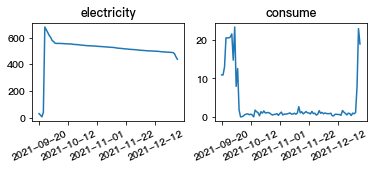

In [29]:
def draw(df):
    x = df['insert_time'].ravel()
    y = df['electricity'].ravel()
    y_ = df['consume'].ravel()
    plt.subplot(2,  2,  1)
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, y)
    plt.title('electricity')

    plt.subplot(2,  2,  2) 
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, y_) 
    plt.title('consume')   
    print(df.head())
    

draw(sample)
    

---

### 6.按日期分析

In [30]:
date_group = df.groupby('insert_time')

In [31]:
date_analysis = date_group.agg(['sum', 'mean']).loc[:, ['consume', 'charge']].reset_index()

In [32]:
date_analysis.head()

insert_time   consume               charge           
                    sum       mean       sum       mean
0  2021-09-20  28030.16   5.743885      0.00   0.000000
1  2021-09-21  27853.16   5.718161  25744.18   5.180958
2  2021-09-22  39819.40   8.203420  42379.60   8.564996
3  2021-09-23  41618.39   8.645283  43685.94   8.893717
4  2021-09-24  56063.98  11.509747  52128.15  10.492784

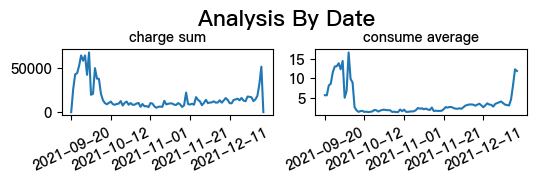

In [33]:
def draw_date(df):
    x = df['insert_time'].ravel()
    y = df['charge']['sum'].ravel()
    y_ = df['consume']['mean'].ravel()
    
    plt.figure(dpi=100)
    plt.suptitle('Analysis By Date', fontsize=16)
    
    plt.subplot(4,  2,  1)
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, y)
    plt.title('charge sum', fontsize=10)

    plt.subplot(4,  2,  2) 
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, y_) 
    plt.title('consume average', fontsize=10)   


draw_date(date_analysis)

可以看到consume average在10月初的时候有一轮骤降，排除爬虫的故障，考虑到是国庆节人员流动导致的电费波动。

In [34]:
# 国庆前后的电费消耗
df[(df['insert_time'] < '2021-10-10') & (df['insert_time'] > '2021-09-15')].groupby('insert_time')['consume'].describe()

,count,mean,std,min,25%,50%,75%,max
insert_time,,,,,,,,
2021-09-20,4880.0,5.743885,4.349534,0.01,3.0100,5.280,7.7725,164.12
2021-09-21,4871.0,5.718161,4.303444,0.01,3.0050,5.280,7.7700,164.12
2021-09-22,4854.0,8.203420,4.336307,0.01,4.9100,7.815,10.9950,34.66
2021-09-23,4814.0,8.645283,4.534765,0.01,5.2825,8.245,11.4800,28.41
2021-09-24,4871.0,11.509747,6.446569,0.01,7.7000,11.180,14.6950,146.42
2021-09-25,4853.0,12.984107,7.487262,0.01,8.8600,12.670,16.7300,291.94
2021-09-26,4873.0,13.044972,5.744070,0.01,9.0500,12.780,16.6200,45.09
2021-09-27,4787.0,13.810978,5.491107,0.01,10.1800,13.720,17.4300,44.51
2021-09-28,4161.0,12.283653,5.341177,0.01,8.6000,12.100,15.6300,41.68


In [35]:
# 寝室用电排行
rank_group = df.groupby('uid').sum().reset_index()

In [36]:
rank_by_dorm = rank_group.loc[:, ['uid','consume']].sort_values('consume', ascending=False).head(10)
rank_by_dorm['room'] = rank_by_dorm['uid'].astype(str).map(uid_map)
rank_by_dorm.head()

,uid,consume,room
4440,4466,1891.48,至诚轩3栋A区-A529
4424,4450,1757.93,至诚轩3栋A区-A513
4324,4350,1717.52,至诚轩3栋A区-A129
4370,4396,1713.11,至诚轩3栋A区-A317
4399,4425,1632.31,至诚轩3栋A区-A417


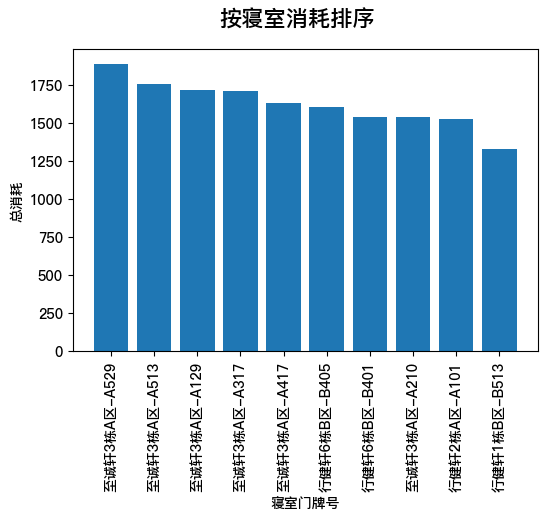

In [37]:
def draw_rank(df):
    x = df['room']
    y = df['consume'].ravel()
   
    plt.figure(dpi=100)
    plt.suptitle('按寝室消耗排序', fontsize=16)

    plt.bar(x, y)
    plt.xlabel('寝室门牌号')
    plt.ylabel('总消耗')
    plt.xticks(range(0, len(x), 1), rotation=90)
    plt.tick_params(labelsize=10)


draw_rank(rank_by_dorm)

---

### 7按照楼栋统计

In [38]:

top3building = df.groupby('buildingid').agg(['sum', 'mean'])\
                 .reset_index().loc[:, ['buildingid', 'consume', 'charge']]\
                 .sort_values(('consume', 'sum'), ascending=False).head(3)

In [39]:
from building_map import building_map
building_decoder = {}
for item in building_map.items():
    building_decoder[item[1]] = item[0]

['155', '1', '29']


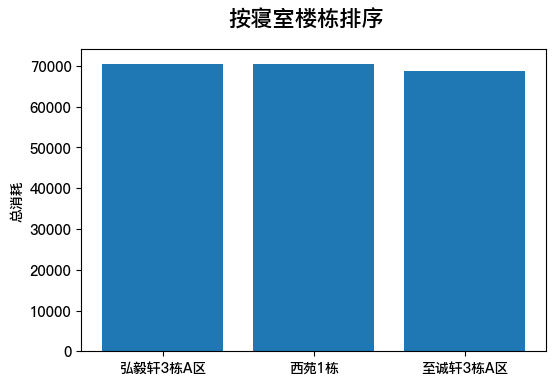

In [40]:
def draw_building_rank(df):
    x = df['buildingid'].astype(str).tolist()
    print(x)
    x = list(map(lambda code: building_decoder[code], x))
    y = df['consume']['sum'].ravel()
   
    plt.figure(dpi=100)
    plt.suptitle('按寝室楼栋排序', fontsize=16)
    
    plt.bar(x, y)
    plt.xlabel('')
    plt.ylabel('总消耗')


draw_building_rank(top3building)

---
### 8气温的趋势考察

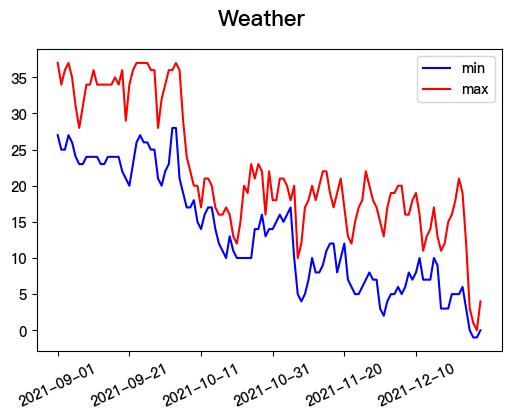

In [41]:
def draw_weaher(df):

    x = df['date'].ravel()
    max = df['max']
    min = df['min']

    plt.figure(dpi=100)
    plt.suptitle('Weather', fontsize=16)
    
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, min, c='b', label='min')
    plt.plot(x, max, c='r', label='max')
    plt.legend()

draw_weaher(weather)

In [42]:
# 将用电量、气温进行归一化
weather['norm_max_temp'] = weather['max'] / weather['max'].max()
weather['norm_min_temp'] = weather['min'] / weather['min'].max()

In [43]:
weather.head()

,date,weather,wind,max,min,norm_max_temp,norm_min_temp
0,2021-09-01,晴/晴,东北风1-2级/东北风1-2级,37,27,1.000000,0.964286
1,2021-09-02,多云/多云,东北风1-2级/东北风1-2级,34,25,0.918919,0.892857
2,2021-09-03,多云/多云,东风1-2级/东风1-2级,36,25,0.972973,0.892857
3,2021-09-04,晴/晴,东北风1-2级/东北风1-2级,37,27,1.000000,0.964286
4,2021-09-05,小雨/多云,西北风1-2级/西北风1-2级,35,26,0.945946,0.928571


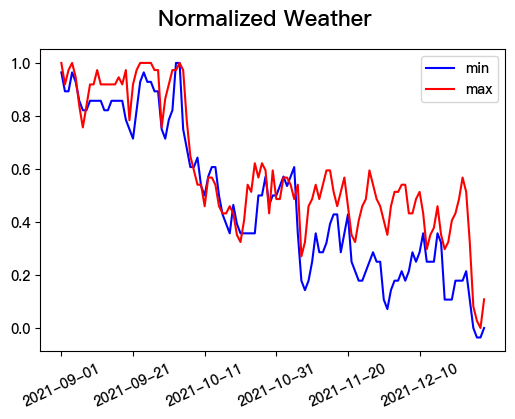

In [44]:
def draw_norm_weaher(df):
    x = df['date'].ravel()
    max = df['norm_max_temp']
    min = df['norm_min_temp']
    
    plt.figure(dpi=100)
    plt.suptitle('Normalized Weather', fontsize=16)
    
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, min, c='b', label='min')
    plt.plot(x, max, c='r', label='max')
    plt.legend()


draw_norm_weaher(weather)

**对最高气温进行验证** 

In [45]:
date_analysis.loc[:, ('consume','norm_sum')] = date_analysis.loc[:, ('consume','sum')] / date_analysis.loc[:, ('consume','sum')].max()

In [46]:
date_analysis.head()

insert_time   consume               charge              consume
                    sum       mean       sum       mean  norm_sum
0  2021-09-20  28030.16   5.743885      0.00   0.000000  0.348693
1  2021-09-21  27853.16   5.718161  25744.18   5.180958  0.346491
2  2021-09-22  39819.40   8.203420  42379.60   8.564996  0.495350
3  2021-09-23  41618.39   8.645283  43685.94   8.893717  0.517729
4  2021-09-24  56063.98  11.509747  52128.15  10.492784  0.697431

/home/hadoop/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


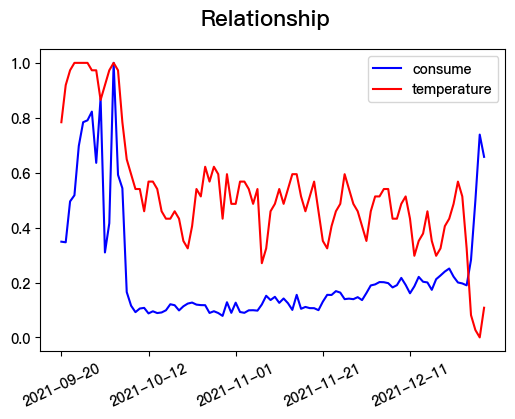

In [47]:
def draw_relationship(weather, date_analysis):
    cols = ['insert_time','consume_sum','consume_mean','charge_sum','charge_mean', \
            'consume_norm_sum', 'date', 'weather', 'wind', 'max', 'min', 'norm_max_temp', 'norm_min_temp']
    merged = pd.merge(date_analysis, weather, left_on='insert_time', right_on='date')
    merged.columns = cols

    x = merged['date'].ravel()
    temp = merged['norm_max_temp']
    consume = merged['consume_norm_sum']

    plt.figure(dpi=100)
    plt.suptitle('Relationship', fontsize=16)
    
    plt.xticks(range(0, len(x), 20), rotation=25)
    plt.plot(x, consume, c='b', label='consume')
    plt.plot(x, temp, c='r', label='temperature')
    plt.legend()

    return merged


merged = draw_relationship(weather, date_analysis)

In [48]:
merged.head()

,insert_time,consume_sum,consume_mean,charge_sum,charge_mean,consume_norm_sum,date,weather,wind,max,min,norm_max_temp,norm_min_temp
0,2021-09-20,28030.16,5.743885,0.00,0.000000,0.348693,2021-09-20,多云/晴,东北风1-2级/东北风1-2级,29,21,0.783784,0.750000
1,2021-09-21,27853.16,5.718161,25744.18,5.180958,0.346491,2021-09-21,晴/晴,东风1-2级/东风1-2级,34,20,0.918919,0.714286
2,2021-09-22,39819.40,8.203420,42379.60,8.564996,0.495350,2021-09-22,晴/晴,东北风1-2级/东北风1-2级,36,23,0.972973,0.821429
3,2021-09-23,41618.39,8.645283,43685.94,8.893717,0.517729,2021-09-23,晴/晴,东风1-2级/东风1-2级,37,26,1.000000,0.928571
4,2021-09-24,56063.98,11.509747,52128.15,10.492784,0.697431,2021-09-24,晴/晴,东南风1-2级/东南风1-2级,37,27,1.000000,0.964286


In [49]:
corr_val = merged['consume_mean'].corr(merged['norm_max_temp'])
print('平均用电量和最高气温的相关性', corr_val)

平均用电量和最高气温的相关性 0.4906272977015717
